In [79]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import math
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from itertools import cycle
from math import ceil
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.decomposition import PCA
from tslearn.barycenters import dtw_barycenter_averaging
print("setup complete")

setup complete


In [80]:
sales = pd.read_csv('70prod_data.csv',\
                    index_col=0, parse_dates=True)

In [81]:
sales.head()

P_1   P_2   P_3   P_4   P_5   P_6   P_7   P_8   P_9  P_10  ...  \
2014-07-31  2669  3603  3506  1274  1528  2244  1460  2523  2045  1713  ...   
2014-08-31  2794  3405  3279  1449  1526  1970  1423  2660  2065  1774  ...   
2014-09-30  2289  3434  3238  1426  1484  1877  1369  2581  1775  1875  ...   
2014-10-31  2310  3277  3088  1404  1500  1615  1159  2326  1614  1893  ...   
2014-11-30  2559  3396  2921  1329  1384  1796  1395  2351  1749  1678  ...   

            P_61  P_62  P_63  P_64  P_65  P_66  P_67  P_68  P_69  P_70  
2014-07-31  1721  2506  3011  1039  1374  1840  1359  1407  1108  1544  
2014-08-31  1906  2701  3081  1134  1331  1877  1424  1503  1061  1490  
2014-09-30  1979  2618  3004  1160  1327  1827  1357  1449  1049  1465  
2014-10-31  1982  2693  3215  1180  1369  1883  1384  1446  1050  1584  
2014-11-30  2025  2607  3280  1065  1286  1766  1345  1377   988  1518  

[5 rows x 70 columns]

In [82]:
sales.describe().T

count         mean         std     min     25%     50%     75%     max
P_1    63.0  3510.761905  656.364885  2289.0  2997.0  3546.0  3992.0  4885.0
P_2    63.0  4341.333333  671.591874  3152.0  3848.0  4464.0  4810.0  5873.0
P_3    63.0  4448.523810  693.352814  2909.0  4105.5  4607.0  4943.0  5644.0
P_4    63.0  2267.888889  435.481014  1274.0  2065.0  2371.0  2541.5  2974.0
P_5    63.0  2390.111111  489.206009  1252.0  2198.5  2492.0  2705.5  3327.0
...     ...          ...         ...     ...     ...     ...     ...     ...
P_66   63.0  2075.317460  231.814082  1742.0  1877.5  2035.0  2231.0  2591.0
P_67   63.0  1685.857143  275.337556  1294.0  1424.0  1645.0  1928.5  2199.0
P_68   63.0  1649.063492  303.335058   748.0  1427.5  1562.0  1915.5  2243.0
P_69   63.0  1420.682540  313.456218   766.0  1164.0  1538.0  1658.5  1968.0
P_70   63.0  1541.317460  171.466899  1152.0  1443.5  1514.0  1653.0  2010.0

[70 rows x 8 columns]

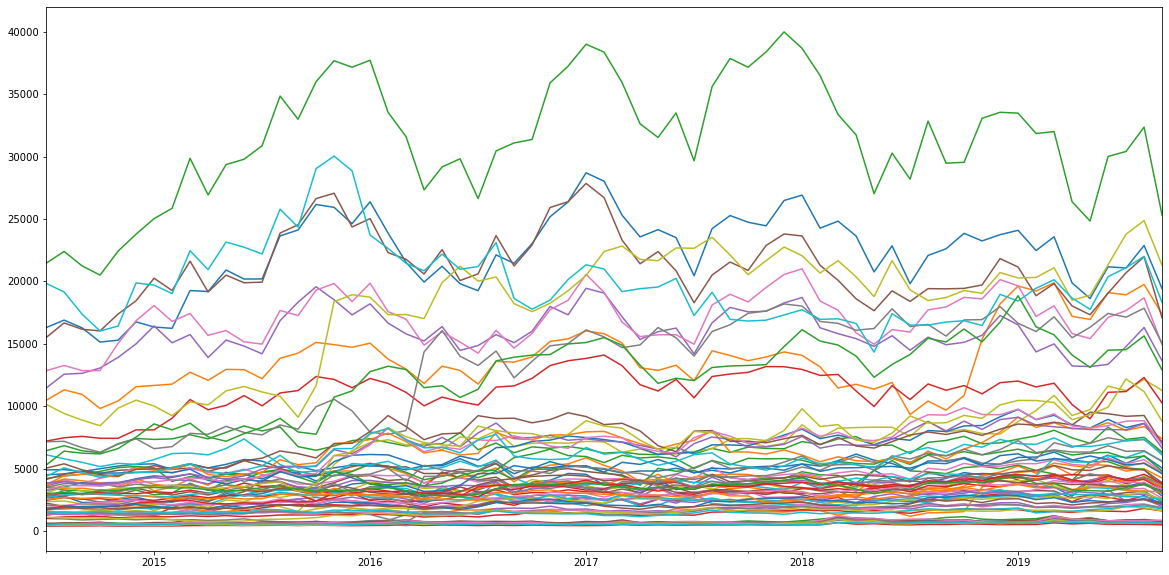

In [83]:
sales.plot(figsize=(20, 10),legend=False)
plt.show()

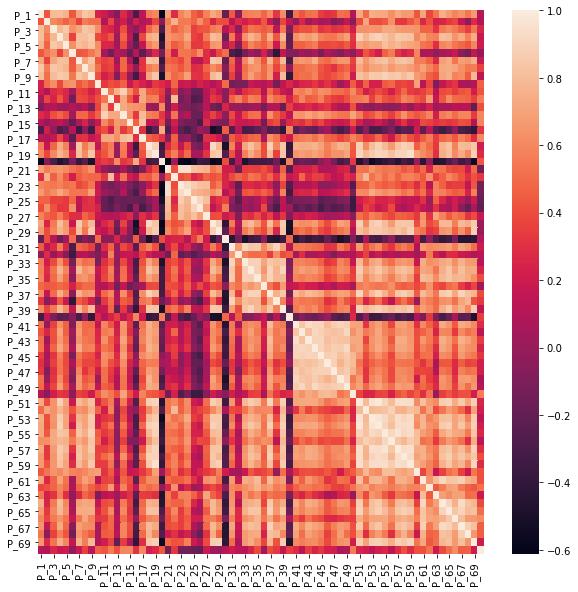

In [84]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(sales.corr())
#interpretation heatmap IMPORTANT

On observe une forte correlation entre certains groupes de produits, ce qui suggère qu'on peut les classifier selon leurs comportements de ventes.


## clustering
L'un des problème qui doit etre traité avant de commencer le partitionnement (clustering) est l'échelle de la série. Sans normaliser les données, les séries qui se ressemblent seront vues si différentes les unes des autres et affecteront la précision du processus de clustering. Nous pouvons voir l'effet de la normalisation dans les images suivantes.


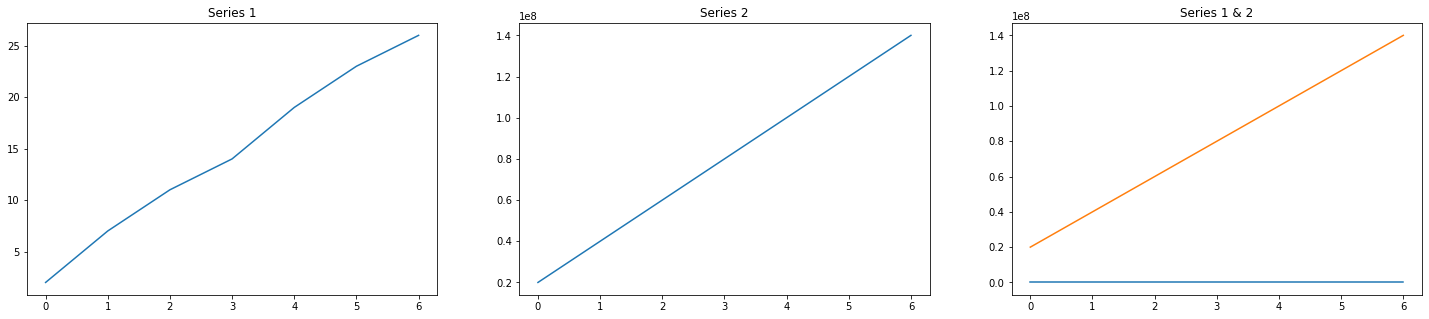

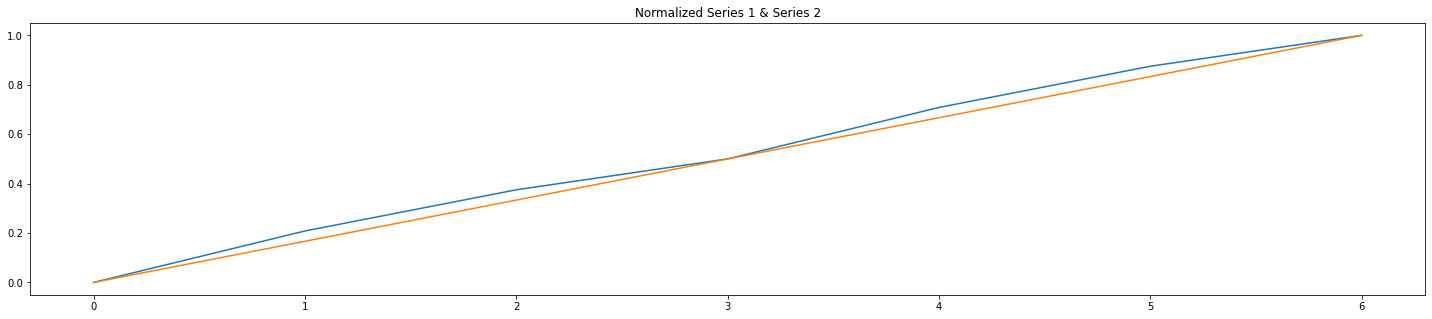

In [85]:
a = [[2],[7],[11],[14],[19],[23],[26]]
b = [[20000000],[40000000],[60000000],[80000000],[100000000],[120000000],[140000000]]
fig, axs = plt.subplots(1,3,figsize=(25,5))
axs[0].plot(a)
axs[0].set_title("Series 1")
axs[1].plot(b)
axs[1].set_title("Series 2")
axs[2].plot(a)
axs[2].plot(b)
axs[2].set_title("Series 1 & 2")
plt.figure(figsize=(25,5))
plt.plot(MinMaxScaler().fit_transform(a))
plt.plot(MinMaxScaler().fit_transform(b))
plt.title("Normalized Series 1 & Series 2")
plt.show()

In [86]:
mySeries = [sales[[col]] for col in sales.columns]
scaler = MinMaxScaler()
for i in range(len(mySeries)):
    mySeries[i] = MinMaxScaler().fit_transform(mySeries[i])
    mySeries[i]= mySeries[i].reshape(len(mySeries[i]))

Afin de regrouper nos séries avec des k-moyennes,les indices temporels des séries chronologiques doivent etre supprimés, et au lieu des valeurs mesurées de chaque date, ils seront considérés comme des caractéristiques différentes et les dimensions d'un seul point de données. 

Puisque la longueur des série temporelles en pratique est souvent importante, un autre problème auquel on doit faire face est la malédiction de la dimensionnalité,ce terme a été inventé pour la première fois par Richard E. Bellman lors de l'examen des problèmes de programmation dynamique. Cela signifie essentiellement que lorsque la dimensionnalité des données augmente, la distance entre les points de données augmente également. Ainsi, ce changement de mesure de la distance affecte gravement les algorithmes basés sur la distance.

Pour résoudre ce problème, on va proceder à l'analyse en composantes principales ACP avant le partitionnement.

In [87]:
pca = PCA(n_components=2)
pca_res = pca.fit_transform(mySeries)

Désormais avec moins de dimensions qu'avant, nous pouvons voir comment nos séries se répartissent en 2 dimensions.

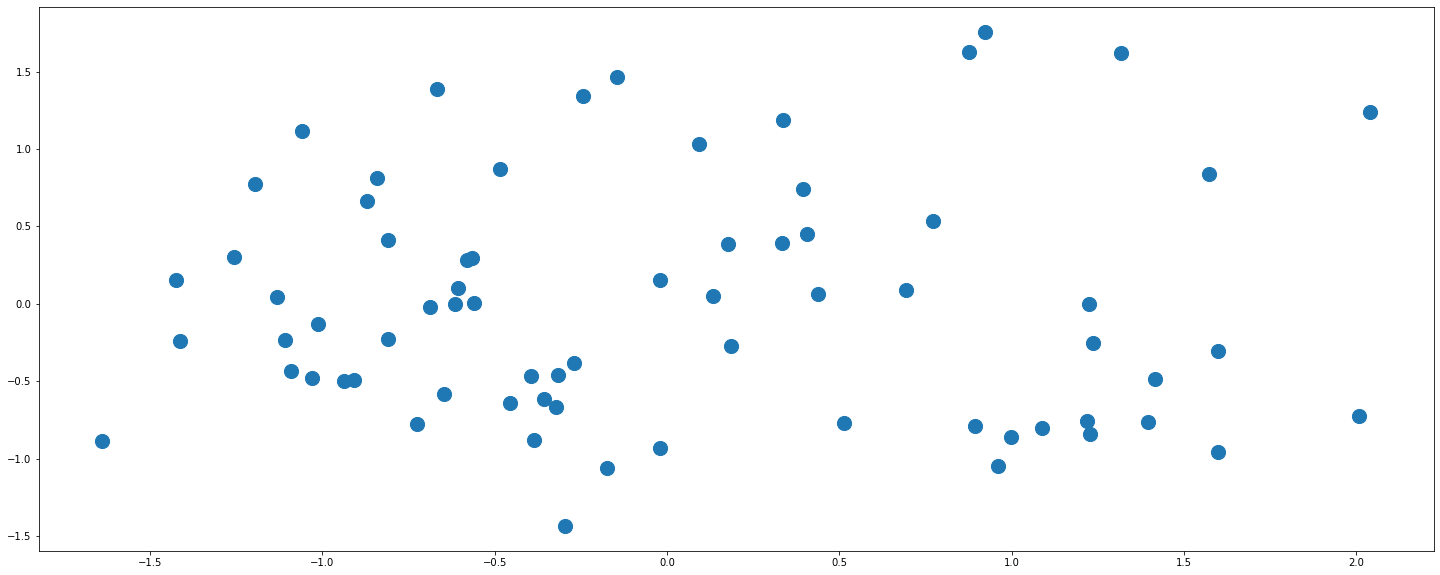

In [88]:
plt.figure(figsize=(25,10))
plt.scatter(pca_res[:,0],pca_res[:,1], s=200)
plt.show()

In [89]:
print(pca_res[:10,:])

[[-0.61355657 -0.00271688]
 [ 0.09205821  1.03059421]
 [-0.87143019  0.66107055]
 [-1.13037105  0.04106856]
 [-0.8099231   0.41134469]
 [-0.24329255  1.34396832]
 [-1.01364043 -0.13216305]
 [-0.56575707  0.29560193]
 [-1.42338057  0.15097156]
 [ 0.33610564  1.18921395]]


Kmeans:
Le partitionnement en k-moyennes (ou k-means en anglais) est une méthode de partitionnement de données et un problème d'optimisation combinatoire. Étant donnés des points et un entier k, le problème est de diviser les points en k groupes, souvent appelés clusters, de façon à minimiser une certaine fonction. On considère la distance d'un point à la moyenne des points de son cluster ; la fonction à minimiser est la somme des carrés de ces distances,la distance euclidienne est souvent utilisée.

Initialement on va estimer le nombre de clusters requis par le racine de nombre de séries qu'on a

In [90]:
cluster_count = math.ceil(math.sqrt(len(mySeries))) 
cluster_count

9

et on va appliquer la méthode de Kmeans sur le résultat de l'ACP.

In [91]:
kmeans = KMeans(n_clusters=cluster_count,max_iter=5000)
labels = kmeans.fit_predict(pca_res)

Après le trainning, on a tracé les résultats. Pour chaque cluster, on a tracé chaque série, un peu transparente et en gris, et afin de voir le mouvement ou la forme du cluster, on a pris la moyenne du cluster et tracé cette série moyenne en rouge.

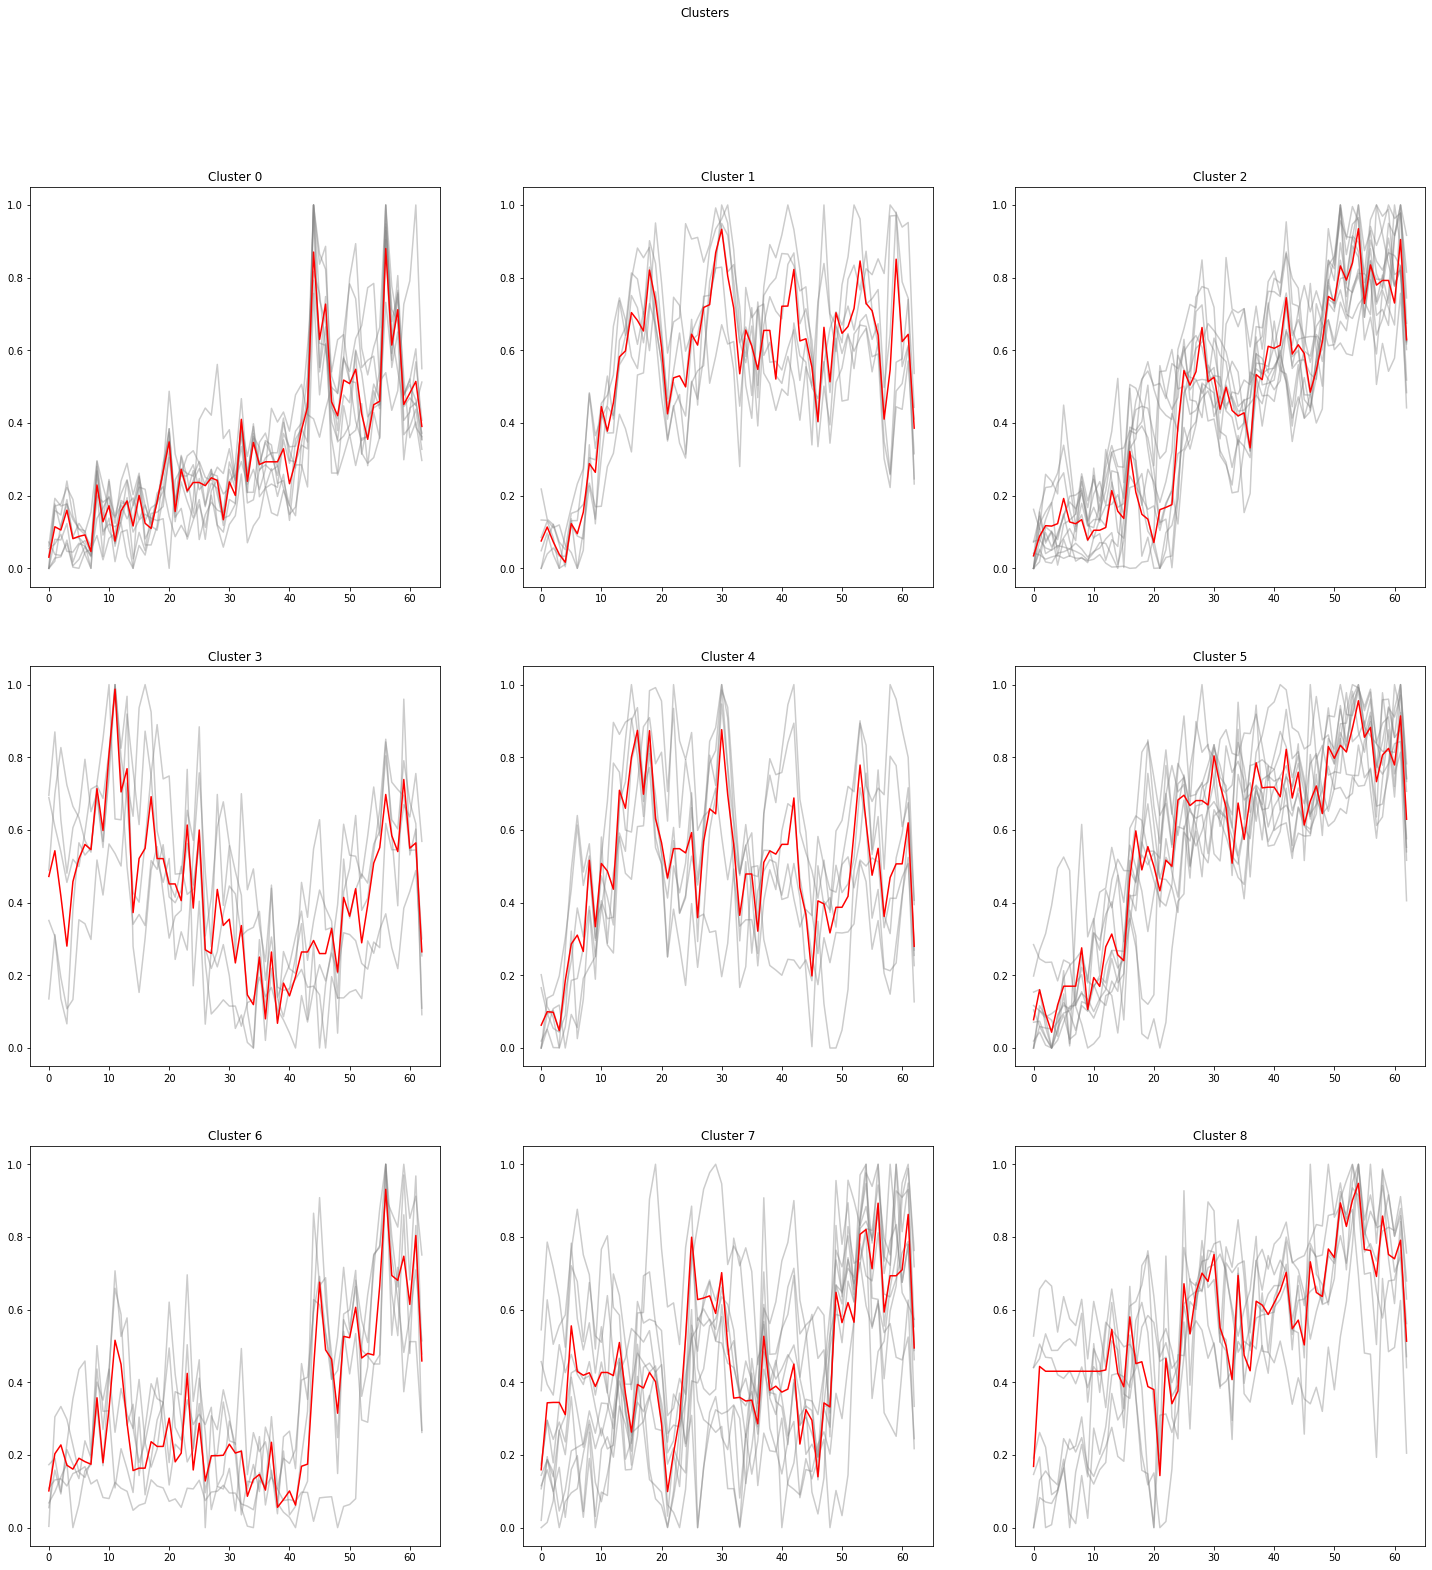

In [92]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(mySeries))))
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                cluster.append(mySeries[i])
    if len(cluster) > 0:
        #axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red") 
        axs[row_i, column_j].plot(dtw_barycenter_averaging(np.vstack(cluster)),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0

plt.show()

Nous pouvons voir la distribution des séries chronologiques en clusters dans le graphique suivant.

les séries semblent uniformement distribuées aux clusters.

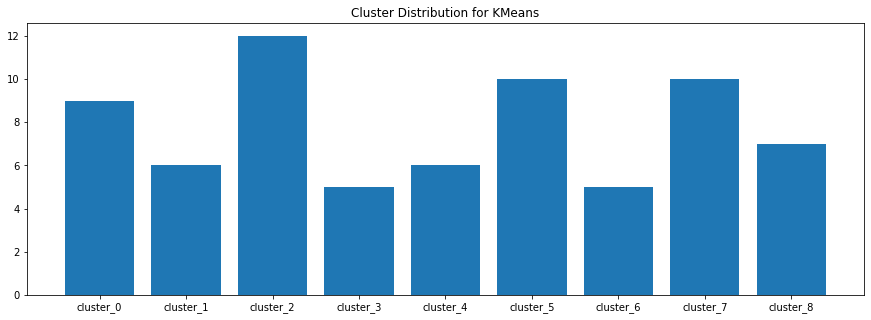

In [93]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["cluster_"+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

Pour bénéficier de partitionnement qu'on a fait, il est nécessaire de lister pour chaque cluster, les séries qui lui appartient.

In [94]:
namesofMySeries=sales.columns
fancy_names_for_labels = [f"Cluster {label}" for label in labels]
groups = pd.DataFrame(zip(namesofMySeries,fancy_names_for_labels),columns=["Series","Cluster"]).\
    sort_values(by="Cluster").set_index("Cluster")
res = pd.DataFrame(zip(sorted(set(fancy_names_for_labels)), \
                       [' ; '.join(sorted(groups[groups.index == label]['Series'], key=lambda x: int(x.split('_')[1]))) for label in sorted(set(fancy_names_for_labels))]),\
                   columns=["Cluster", "Series"]).set_index("Cluster")
res

Series
Cluster                                                     
Cluster 0  P_41 ; P_42 ; P_43 ; P_44 ; P_45 ; P_47 ; P_48...
Cluster 1              P_3 ; P_5 ; P_21 ; P_23 ; P_24 ; P_56
Cluster 2  P_18 ; P_19 ; P_34 ; P_35 ; P_37 ; P_39 ; P_51...
Cluster 3                   P_13 ; P_16 ; P_20 ; P_30 ; P_40
Cluster 4              P_2 ; P_6 ; P_10 ; P_25 ; P_26 ; P_27
Cluster 5  P_4 ; P_7 ; P_9 ; P_28 ; P_29 ; P_33 ; P_54 ; ...
Cluster 6                   P_11 ; P_12 ; P_14 ; P_46 ; P_50
Cluster 7  P_15 ; P_17 ; P_22 ; P_32 ; P_36 ; P_60 ; P_62...
Cluster 8       P_1 ; P_8 ; P_31 ; P_38 ; P_52 ; P_53 ; P_68

D'aprés ce tableau, on peut construire maintenant \
Pour faire des prévision pour un produit, en plus de ces ventes on va compter sur les ventes des produits dans le même cluster.

Pour l'ulistration de la méthode on va choisir un produit parmi chaque cluster.\
Au lieu de choisir aléatoirement, il est mieux de choisir parmi chaque cluster, le produit le plus proche au centre du cluster, càd le plus proche au autre produits au même group.

In [95]:
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, pca_res)
closest

array([43,  2, 18, 29,  5, 54, 49, 21, 37], dtype=int64)

Pour visualiser ce résultat, on va tracer les groups des points avec le centre de chaque (des étoiles) group ansi que le point plus proche à chaque centre (en rouge).

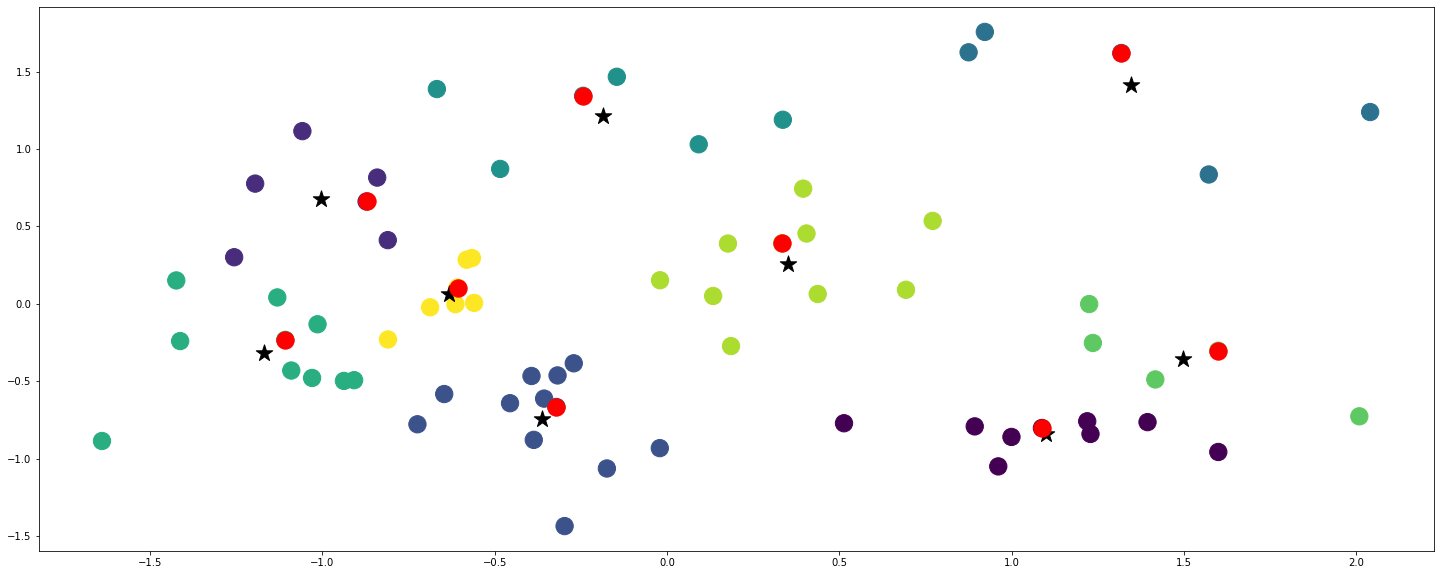

In [116]:
plt.figure(figsize=(25,10))
plt.scatter(pca_res[:, 0], pca_res[:, 1], c=labels, s=300)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='*', c='black', s=300)
plt.scatter(pca_res[closest, 0], pca_res[closest, 1], c='red', s=300)
plt.show()

pour re vérifier ces résultats, on peut voir que les séries choisis sont centrées pour chaque group. 

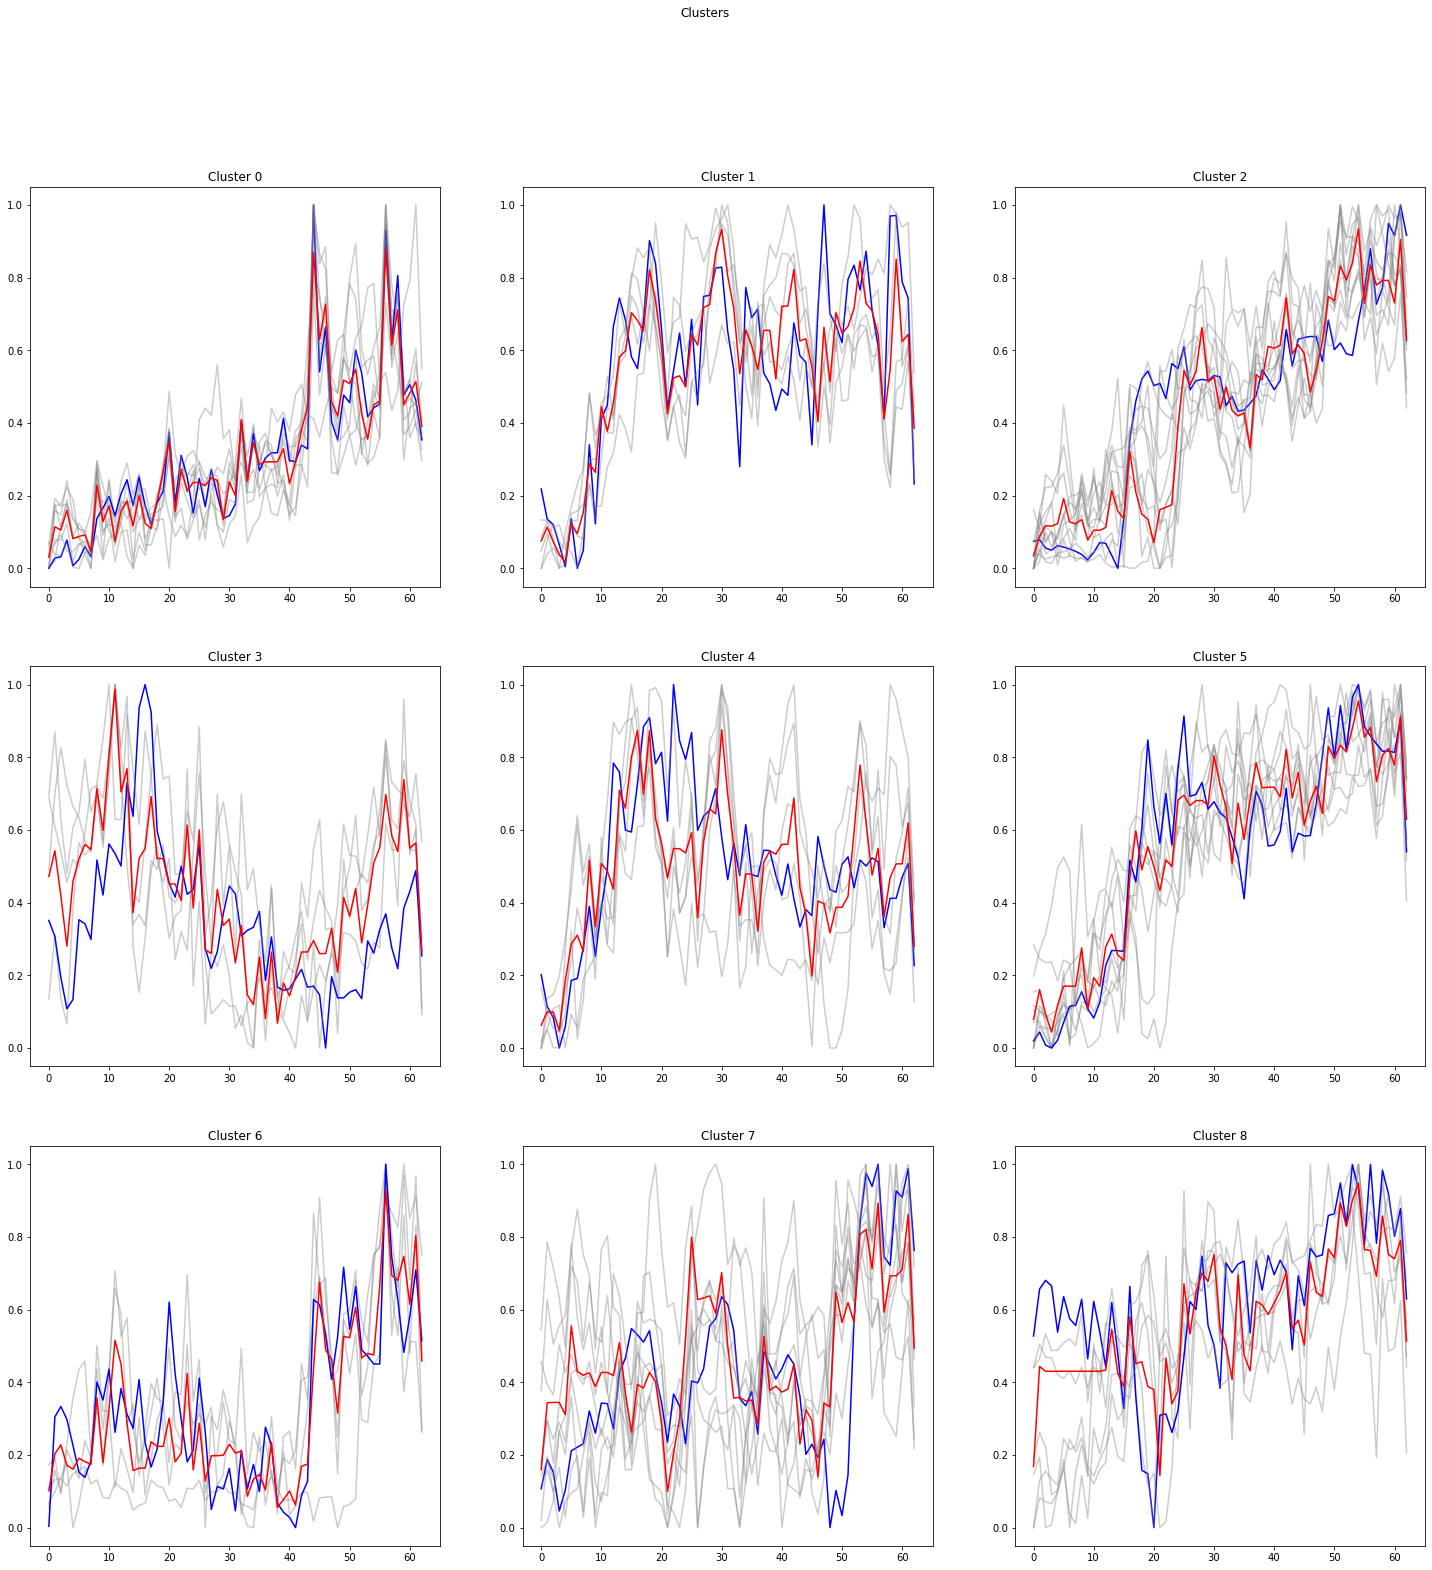

In [117]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(mySeries))))
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                if i not in closest :
                    axs[row_i, column_j].plot(mySeries[i], c="gray",alpha=0.4)
                else : 
                    axs[row_i, column_j].plot(mySeries[i],c="blue")
                cluster.append(mySeries[i])
    if len(cluster) > 0:
        #axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red") 
        axs[row_i, column_j].plot(dtw_barycenter_averaging(np.vstack(cluster)),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0

plt.show()

On a extrait ces séries "centrales" et construit un nouvelle des séries temporelles

In [98]:
sales_s = sales.iloc[:,sorted(closest)]
sales_s.head()

P_3   P_6  P_19   P_22   P_30  P_38  P_44  P_50  P_55
2014-07-31  3506  2244  2366  10467  19852  3510   400   495  3849
2014-08-31  3279  1970  2412  11319  19164  3804   408   580  3980
2014-09-30  3238  1877  2173  10956  17382  3859   409   588  3787
2014-10-31  3088  1615  2107   9822  16034  3823   422   578  3745
2014-11-30  2921  1796  2242  10427  16430  3535   402   558  3861

Puisque les produits choisis appartient à des groups différents, on voit une gande dissemblance entre  leurs caractéristiques statistiques.

In [99]:
sales_s.describe().T

count          mean          std      min      25%      50%      75%  \
P_3    63.0   4448.523810   693.352814   2909.0   4105.5   4607.0   4943.0   
P_6    63.0   3182.793651   668.663283   1615.0   2863.0   3176.0   3508.5   
P_19   63.0   6426.492063  2838.761997   1581.0   4178.0   7046.0   8080.5   
P_22   63.0  13833.523810  2646.570080   9339.0  11800.0  13541.0  15096.5   
P_30   63.0  19873.571429  3179.000090  14339.0  17350.5  19426.0  21268.5   
P_38   63.0   3731.333333   485.265142   2310.0   3481.0   3797.0   4012.5   
P_44   63.0    487.539683    59.505713    400.0    448.5    477.0    517.5   
P_50   63.0    587.650794    61.305464    494.0    540.5    578.0    628.5   
P_55   63.0   6718.682540  1551.085778   3745.0   5570.0   6991.0   7946.5   

          max  
P_3    5644.0  
P_6    4733.0  
P_19  12149.0  
P_22  19889.0  
P_30  30048.0  
P_38   4586.0  
P_44    683.0  
P_50    776.0  
P_55   9120.0

Ce qu'on peur reconfirmer graphiquement

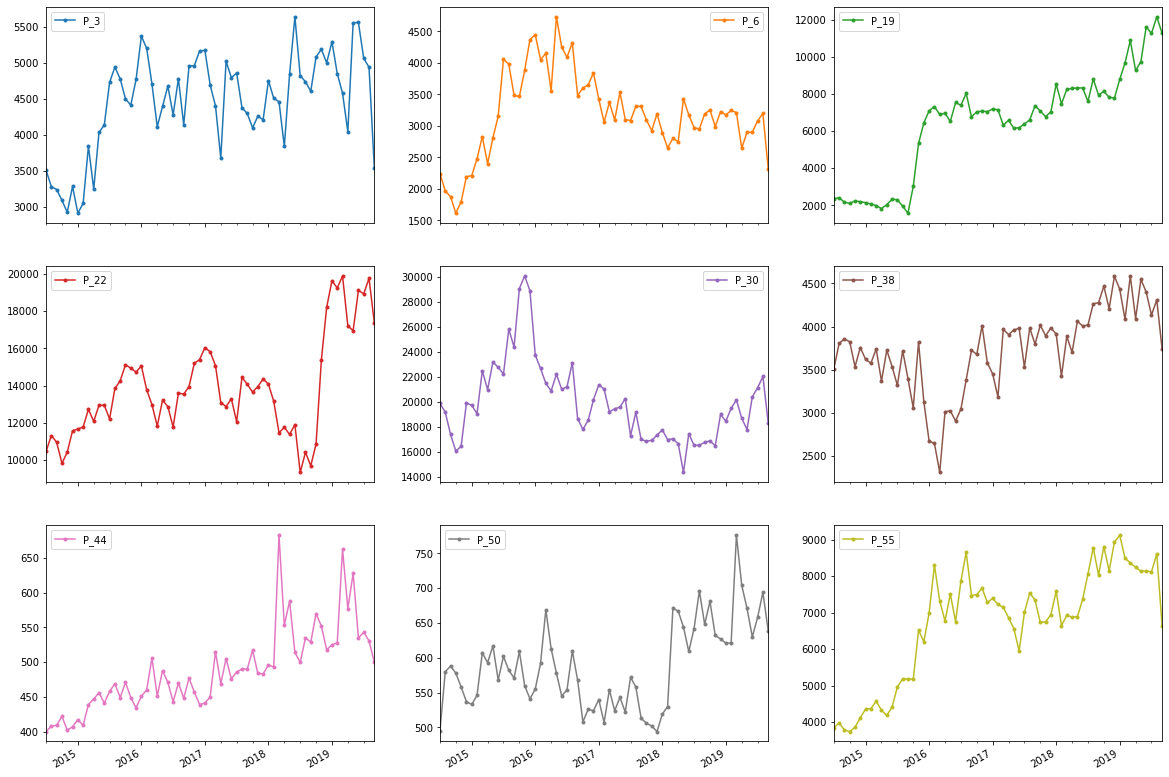

In [121]:
sales_s.plot(subplots=True,layout=(3,3),figsize=(20,15), marker='.')
plt.show()

## Moyenne mobile des séries

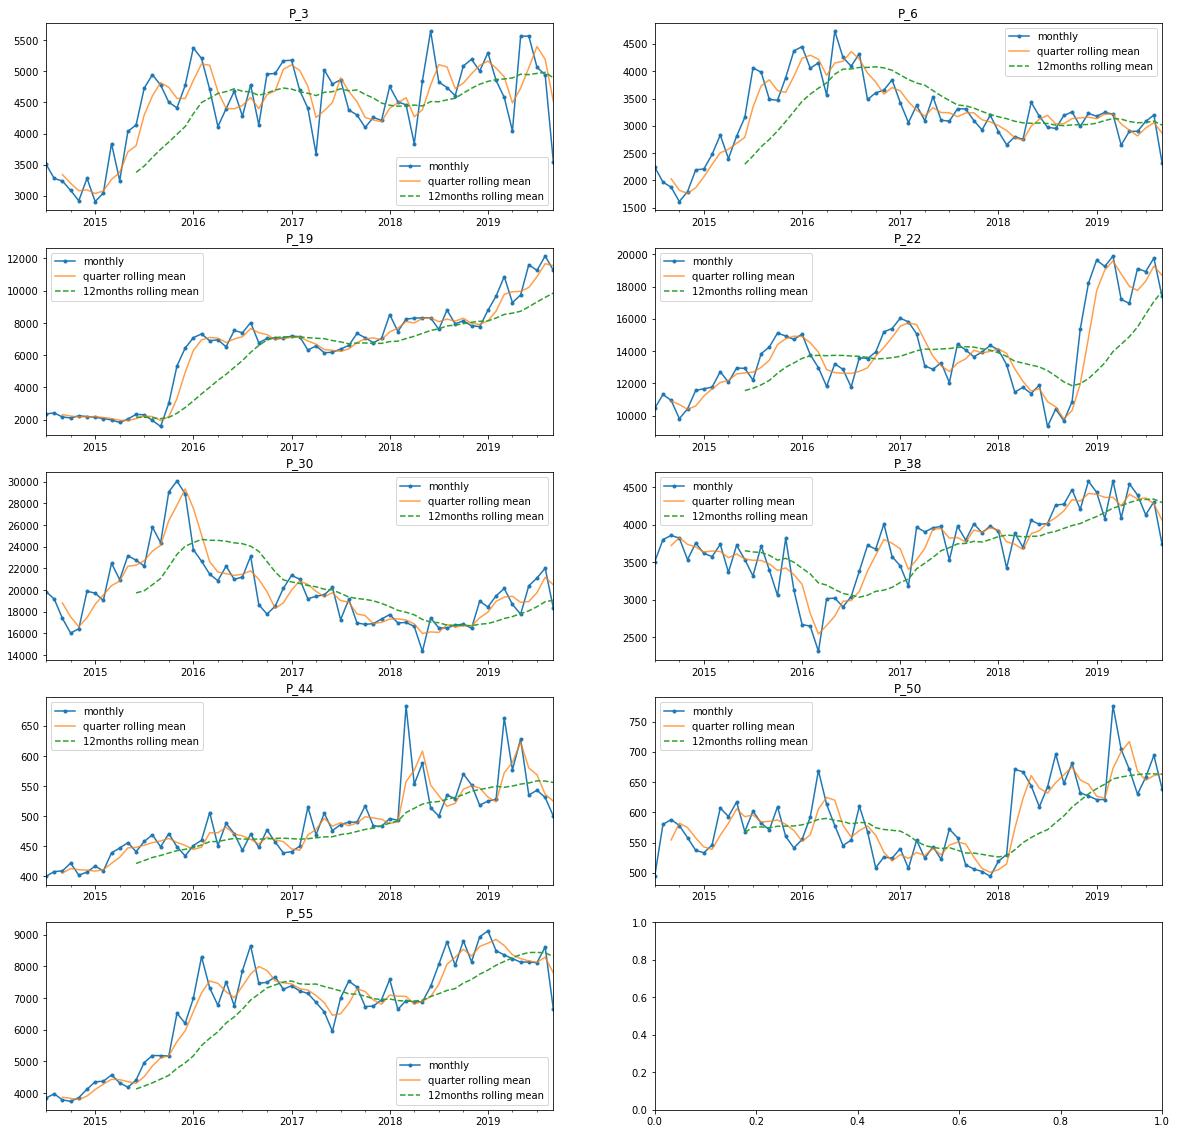

In [101]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20))
axs = axs.flatten()
cols = [next(color_cycle), next(color_cycle), next(color_cycle)]
for i, item in enumerate(sales_s.columns):
    sales_s[item].plot(title=item,
                     color=cols[0],
                     ax=axs[i],
                     marker='.', label="monthly")
    sales_s[item].rolling(3).mean().plot(
                     color=cols[1],
                     ax=axs[i], label="quarter rolling mean", alpha=0.75)
    sales_s[item].rolling(12).mean().plot(
                     color=cols[2],
                     ax=axs[i], linestyle='--', label="12months rolling mean")
    axs[i].legend()

## visualisation de la saisonnalité

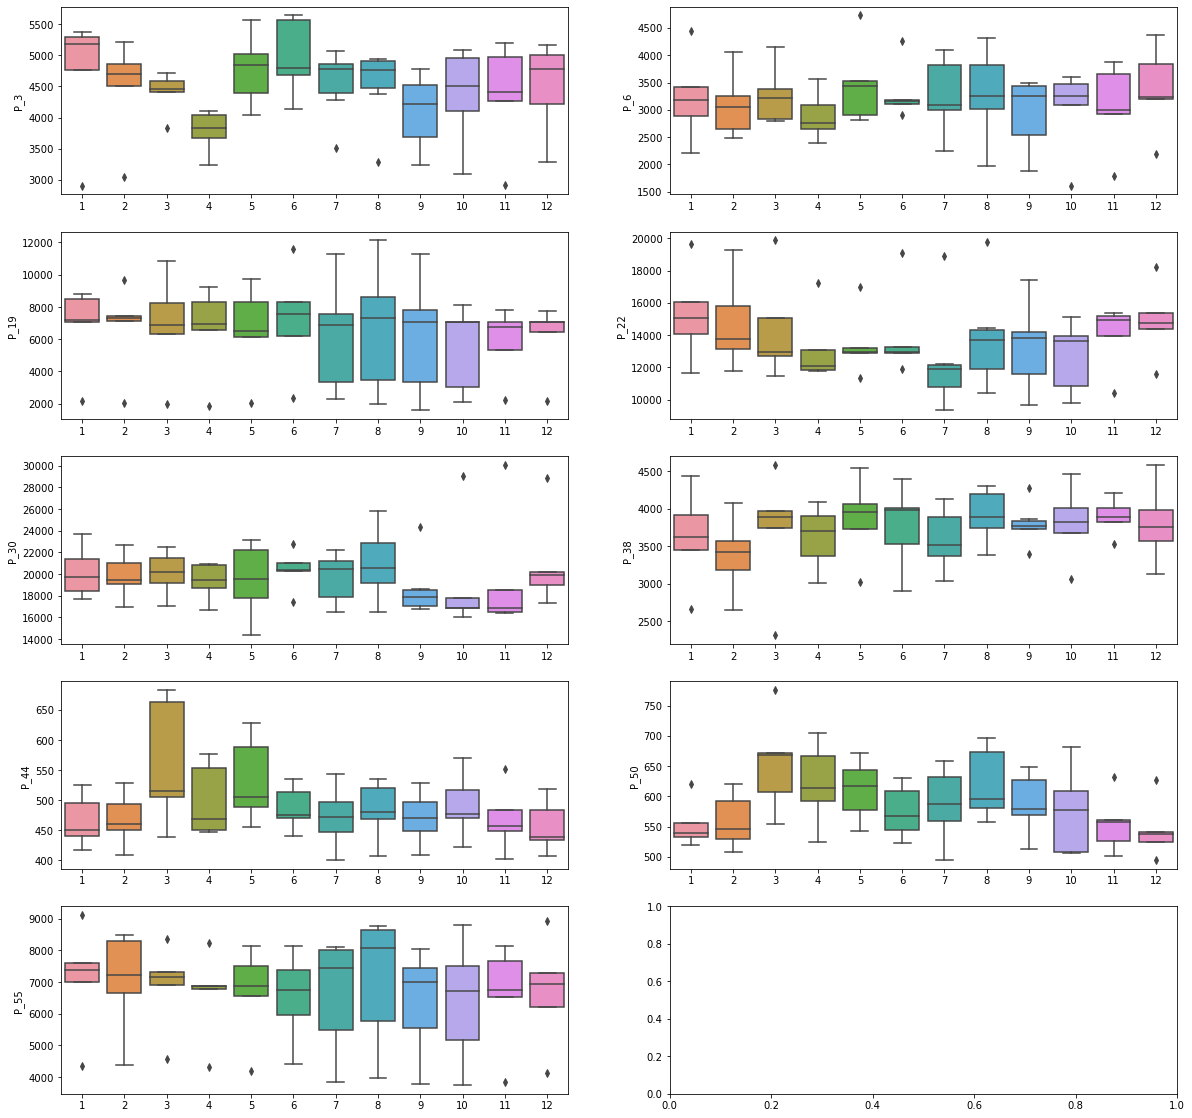

In [104]:
fig, axes = plt.subplots(5, 2, figsize=(20, 20))
axes = axes.flatten()
for name, ax in zip(sales_s.columns, axes):
    sns.boxplot(data=sales_s, x=sales_s.index.month, y=name, ax=ax)

## Décomposition des séries

In [105]:
def plotseasonal(res, axes, name):
    res.observed.plot(ax=axes[0], legend=False, title=name)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False, marker='o', linestyle='', markersize=5)
    axes[3].set_ylabel('Residual')
    plotseasonal.counter += 1
def grid_plotseasonal(df, ncol):
    nrow=ceil(len(df.columns)/ncol)*4
    fig, axes = plt.subplots(ncols=ncol, nrows=nrow, sharex=True, figsize=(15,1.5*nrow))
    plotseasonal.counter, k = 0, 0
    for i,col in enumerate(df.columns):
        res = seasonal_decompose(df[col].dropna(), period=12, filt=None)
        plotseasonal(res, axes[k:k+4, i%ncol], col)
        if (i%ncol)==(ncol-1) : k+=4
    plt.tight_layout()
    plt.show()

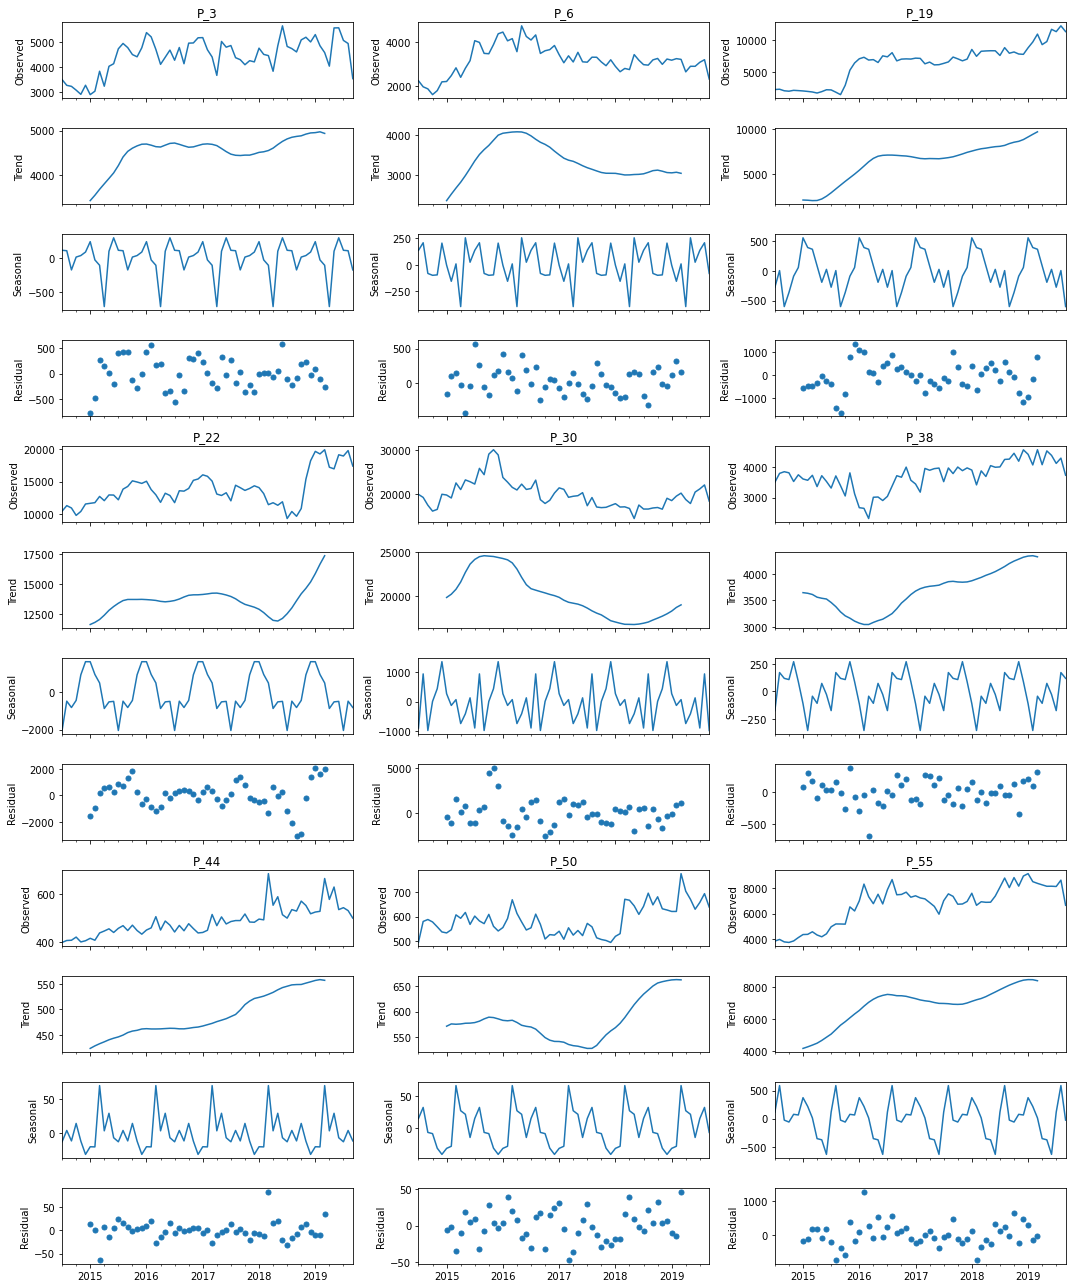

In [106]:
grid_plotseasonal(sales_s, ncol=3)

La fonction season_decompose peut être utilisée pour l'analyse des portions de chaque composant de la série chronologique. Ceci est particulièrement utile pour déterminer l'absorption des résidus dans les données, sur la base des données décomposées. Le volume de cette absorption implique la prévisibilité de la série chronologique - plus les résidus sont élevés, moins la prévisibilité. Dans une certaine mesure, la proportion des résidus par rapport à la tendance et à la saisonnalité peut également être illustrée par les graphiques des moyennes mobiles et des écarts-types ci-dessus.

In [122]:
d = pd.DataFrame(0, index=sales_s.columns, columns=["RESMEAN","OBSMEAN","PERC"], dtype=float)
for col in sales_s.columns:
    result = seasonal_decompose(sales_s[col], period=12, model='additive')
    res, obs = result.resid, result.observed
    d.loc[col][:2] = list(map(lambda x: np.mean(np.abs(x)), (res, obs[~np.isnan(res)])))
d.PERC = d.RESMEAN*100/d.OBSMEAN
d.round(2)

RESMEAN   OBSMEAN  PERC
P_3    236.98   4553.41  5.20
P_6    161.56   3368.08  4.80
P_19   501.28   6393.80  7.84
P_22   814.70  13678.31  5.96
P_30  1130.08  20098.61  5.62
P_38   150.17   3677.69  4.08
P_44    13.13    489.27  2.68
P_50    17.46    582.16  3.00
P_55   261.75   6902.75  3.79

Un diagramme de décalage (lag plot) est un nuage de points pour une série chronologique et les mêmes données décalées. Avec un tel graphe, nous pouvons vérifier s'il existe une corrélation possible entre les ventes ce mois et le mois précédent.

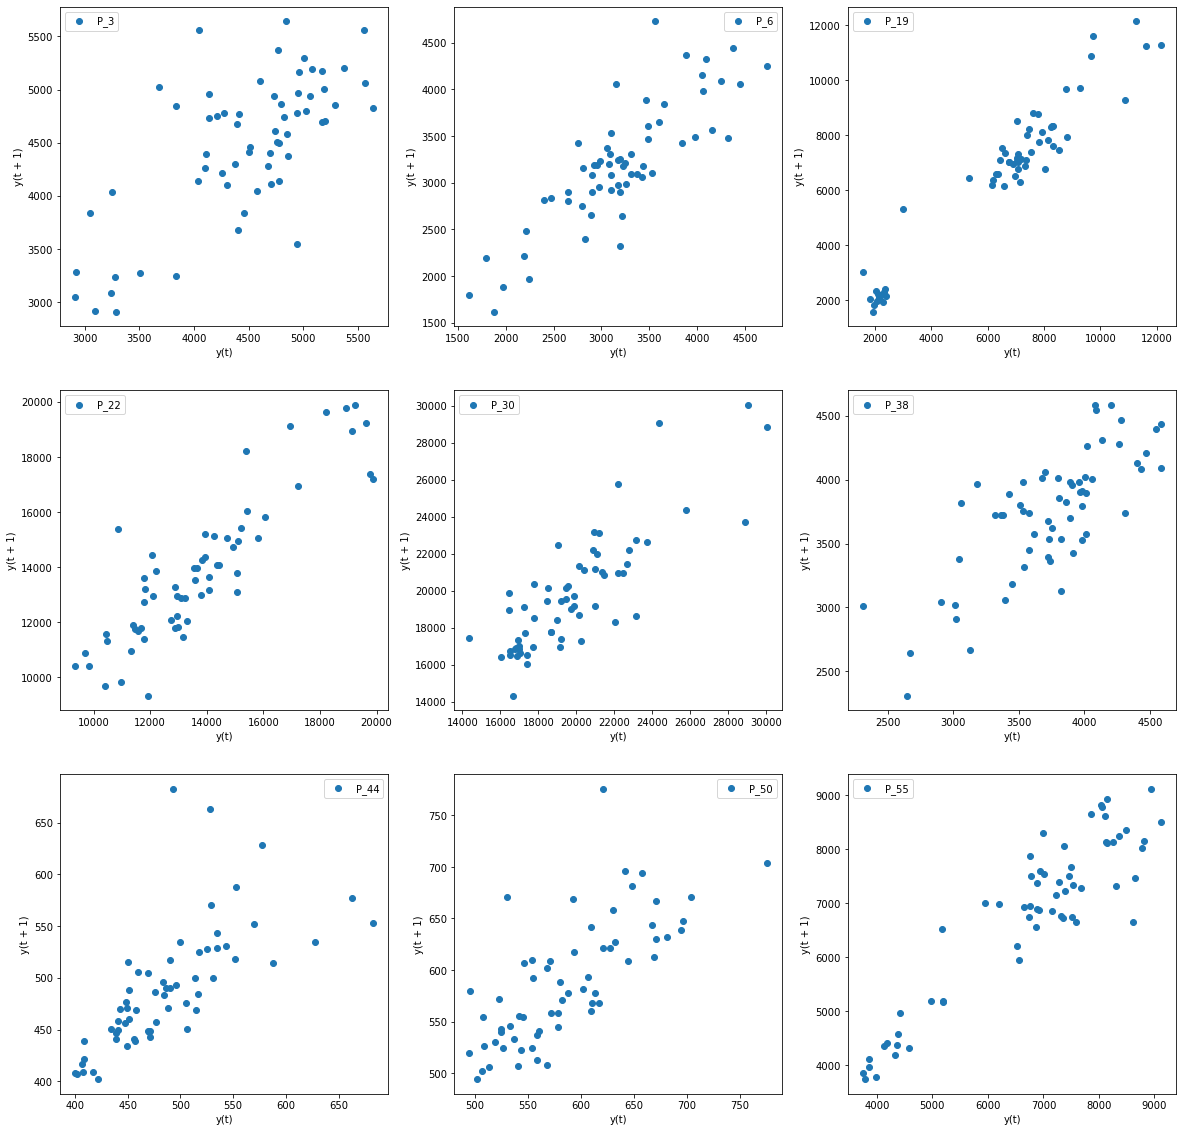

In [108]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.flatten()
for name, ax in zip(sales_s.columns, axes):
    lag_plot(sales_s[name], ax=ax, label=name)
    ax.legend()

## Analyse d'autocorrélation

L'analyse d'autocorrélation illustre le potentiel de prédiction des données de séries chronologiques. Les graphiques d'autocorrélation résument graphiquement la force d'une relation avec une observation dans une série chronologique avec des observations à des pas de temps antérieurs. Le coefficient de Pearson est utilisé pour mesurer l'autocorrélation. Ainsi, l'analyse suivante n'est pertinente que pour les données avec une distribution gaussienne normale.

Un tracé de l'autocorrélation d'une série chronologique par décalage est appelé la fonction d'autocorrélation (ACF). Ce graphique est parfois appelé corrélogramme ou graphique d'autocorrélation. Le graphique montre la valeur de décalage le long de l'axe des x et la corrélation sur l'axe des y entre -1 et 1. Les intervalles de confiance sont dessinés sous forme de cône. Par défaut, il est défini sur un intervalle de confiance de 95%, ce qui suggère que les valeurs de corrélation en dehors de ce code sont très probablement une corrélation.

En général, la corrélation «partielle» entre deux variables est la quantité de corrélation entre elles qui n'est pas expliquée par leurs corrélations mutuelles avec un ensemble spécifié d'autres variables. Par exemple, si nous régressons une variable Y sur d'autres variables X1, X2 et X3, la corrélation partielle entre Y et X3 est la quantité de corrélation entre Y et X3 qui n'est pas expliquée par leurs corrélations communes avec X1 et X2.

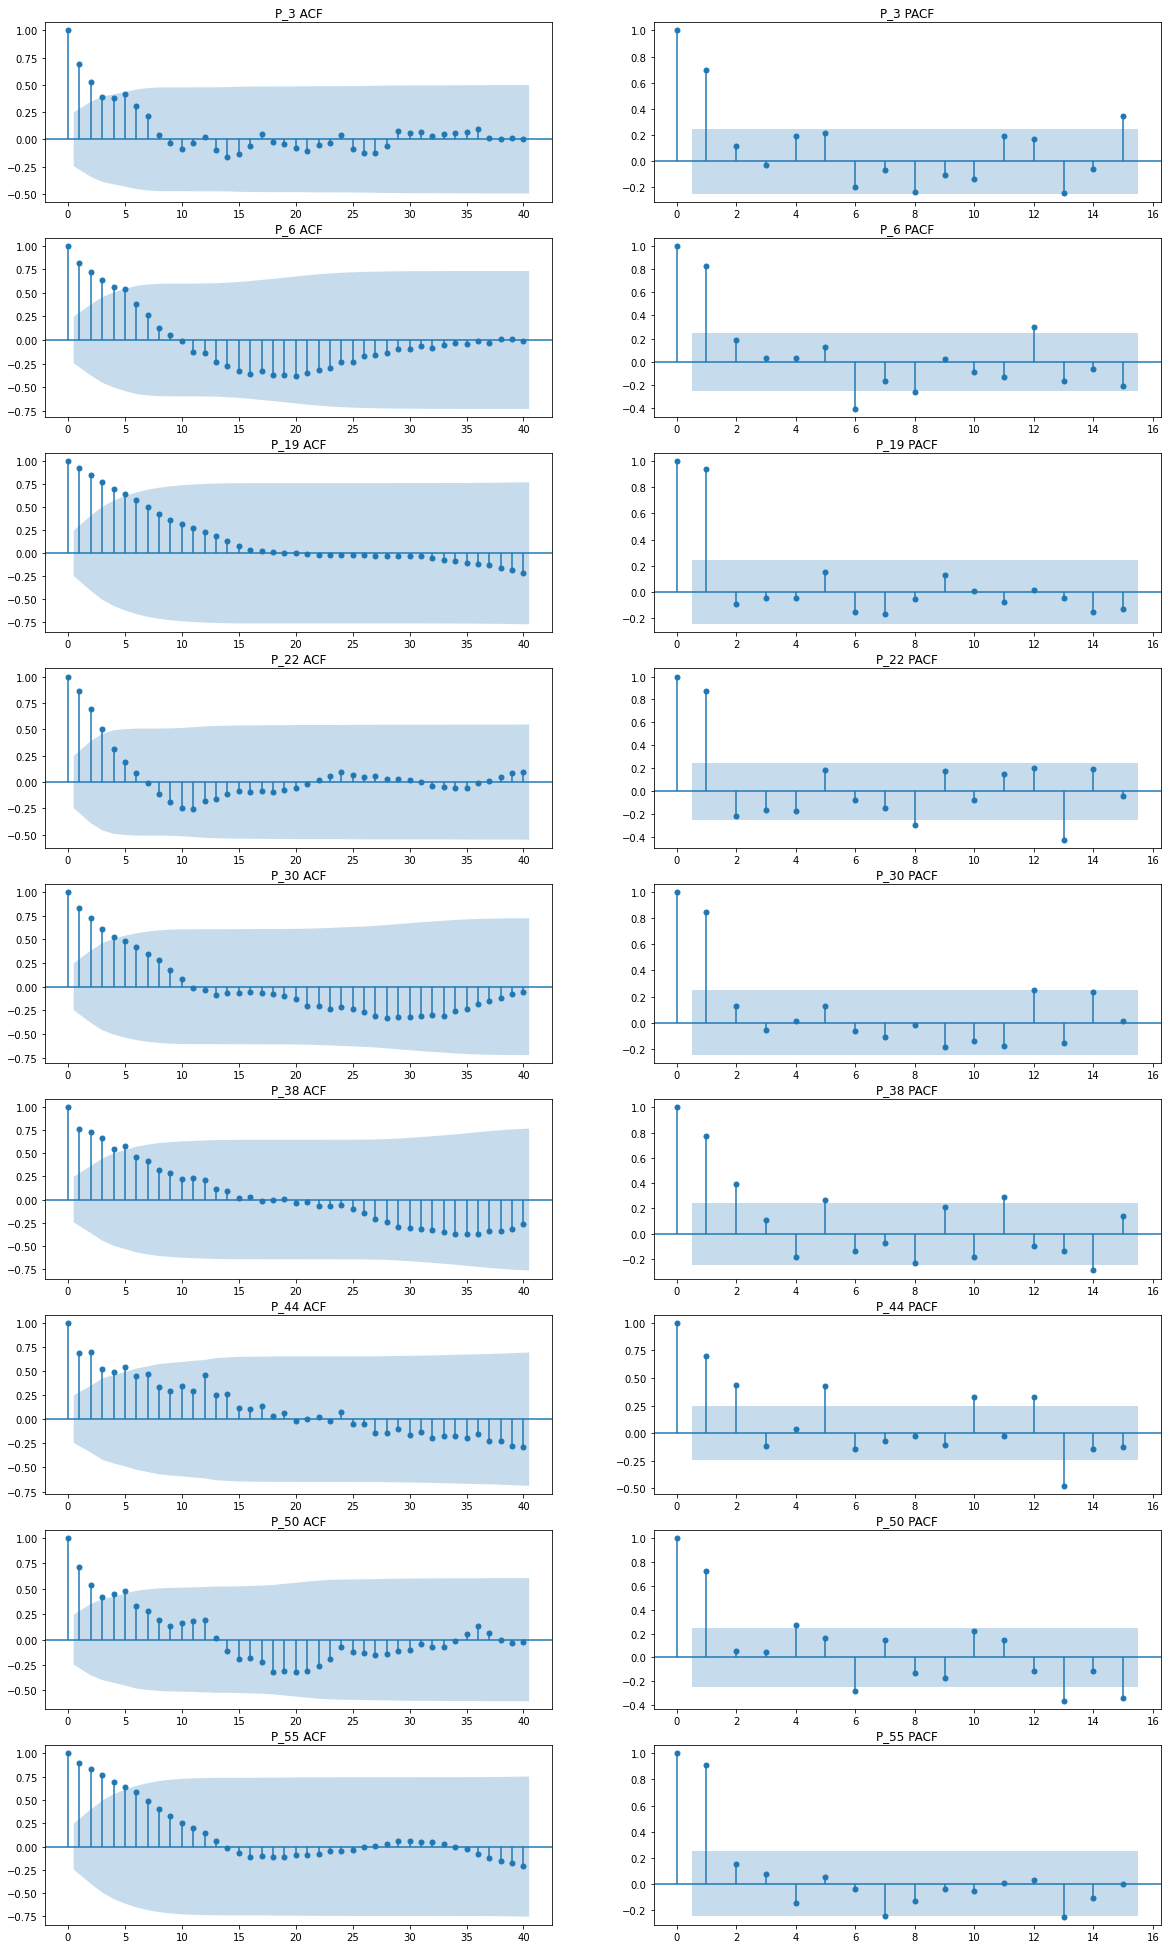

In [109]:
fig, axes = plt.subplots(9, 2, figsize=(20, 35), sharex=False)
alpha=.05
for i, col in enumerate(sales_s.columns):
    sm.graphics.tsa.plot_acf(sales[col].values.squeeze(), lags=40, ax=axes[i,0], title=f"{col} ACF", alpha=alpha)
    sm.graphics.tsa.plot_pacf(sales[col].values.squeeze(), lags=15, ax=axes[i,1], title=f"{col} PACF", alpha=alpha)

### Frome these resources : 

https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

https://learn.co/lessons/dsc-3-25-09-time-series-decomposition

In [110]:
# Import the check_stationarity function from previous lab
def stationarity_check(TS):
    # Calculate rolling statistics
    rolmean = TS.rolling(window = 8, center = False).mean()
    rolstd = TS.rolling(window = 8, center = False).std()
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS) # change the passengers column as required 
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    return None

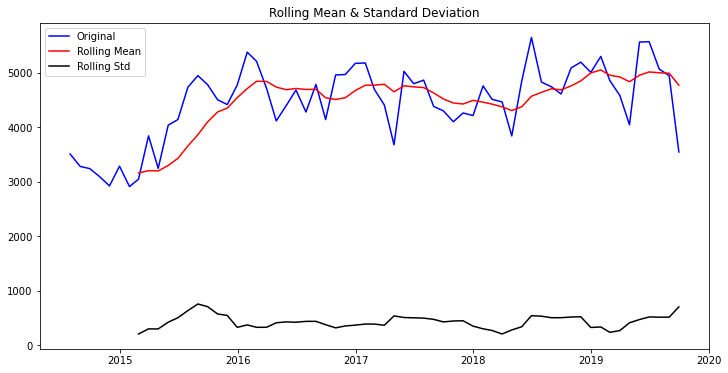

Results of Dickey-Fuller Test:
Test Statistic                 -2.892930
p-value                         0.046176
#Lags Used                      2.000000
Number of Observations Used    60.000000
Critical Value (1%)            -3.544369
Critical Value (5%)            -2.911073
Critical Value (10%)           -2.593190
dtype: float64


In [123]:
stationarity_check(sales_s.P_3)

différenciation d'ordre 1

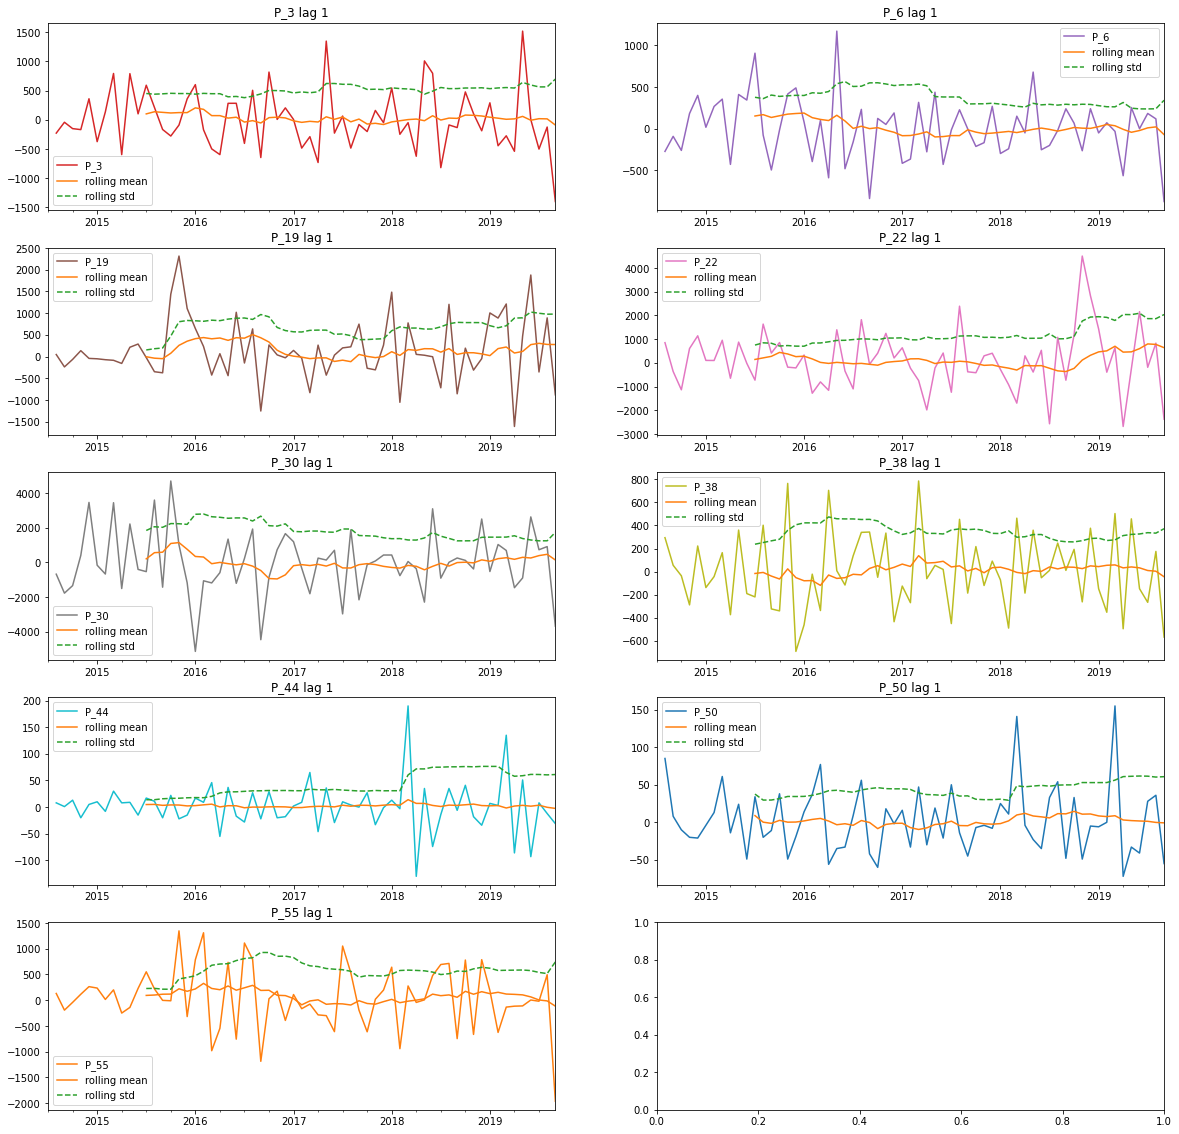

In [102]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20))
axs = axs.flatten()
for i, item in enumerate(sales_s.columns):
    sales_s[item].diff().plot(title=f"{item} lag 1",
                     color=next(color_cycle),
                     ax=axs[i])
    sales_s[item].diff().rolling(12).mean().plot(
                     color=cols[1],
                     ax=axs[i], label="rolling mean")
    sales_s[item].diff().rolling(12).std().plot(
                     color=cols[2],
                     ax=axs[i], linestyle='--', label="rolling std")
    axs[i].legend()

différenciation d'ordre 2, lag1 puis lag m

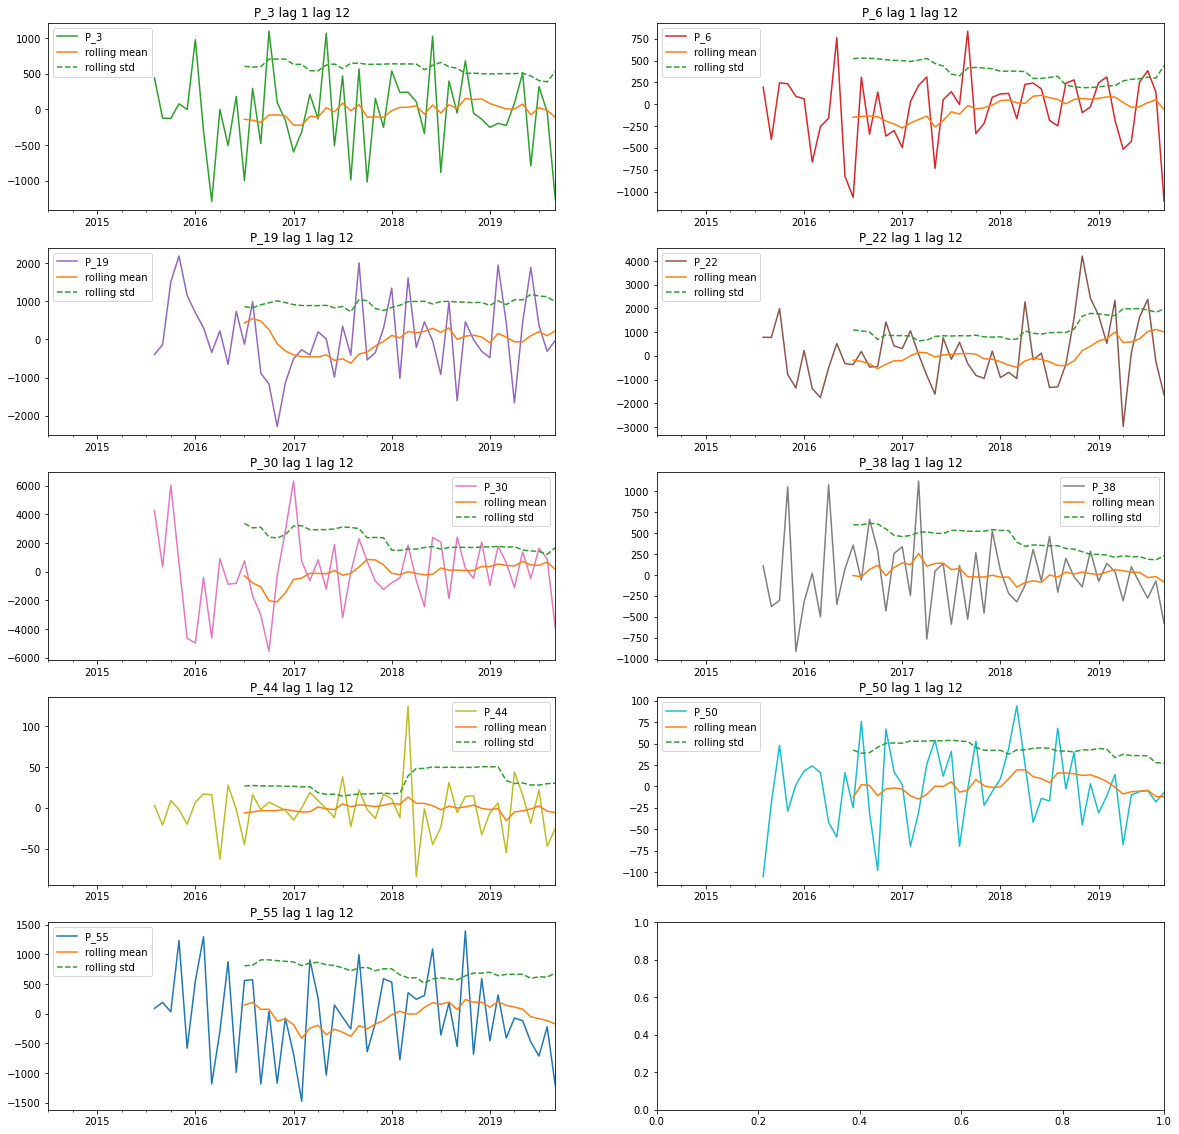

In [103]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20))
axs = axs.flatten()
for i, item in enumerate(sales_s.columns):
    sales_s[item].diff(1).diff(12).plot(title=f"{item} lag 1 lag 12",
                     color=next(color_cycle),
                     ax=axs[i])
    sales_s[item].diff(1).diff(12).rolling(12).mean().plot(
                     color=cols[1],
                     ax=axs[i], label="rolling mean")
    sales_s[item].diff(1).diff(12).rolling(12).std().plot(
                     color=cols[2],
                     ax=axs[i], linestyle='--', label="rolling std")
    axs[i].legend()